In [1]:
%matplotlib inline

In [2]:
%matplotlib notebook
import multiprocessing as mp
mp.set_start_method('forkserver')

In [3]:
import torch.nn.functional as F
import torch
torch.cuda.set_device(0)
import torch.nn as nn
from torch.nn.utils import weight_norm, spectral_norm
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import numpy as np
import numpy as np 
from matplotlib import pyplot as plt
from torch.optim import *
from InvertibleResnet import *

In [4]:
from torch.distributions import *
dist = 3
std = 1
ndim = 2
gaussian = Normal(0.0,std)
normal_np = gaussian.sample((20000,ndim)).numpy()

# m = Exponential(1)
# exp_np = m.sample((500,ndim)).numpy()
# print(exp_np.shape)
# normal_np = np.concatenate([normal_np,exp_np])
binomial = Binomial(1, probs=0.5)
bern_np = (binomial.sample((20000,)).numpy() - 0.5) * (dist*2)
normal_np[:,0] += bern_np
bern_np = (binomial.sample((20000,)).numpy() - 0.5) * (dist*2)
normal_np[:,1] += bern_np

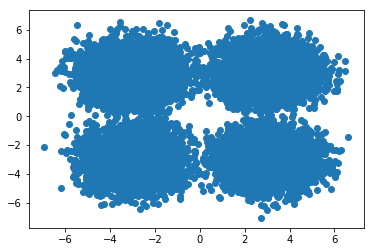

In [5]:
%matplotlib inline
plt.scatter(normal_np[:,0], normal_np[:,1])

In [6]:
dists = torch.from_numpy(np.array([[dist,-dist], [dist, dist], [-dist, dist], [-dist,-dist]]).astype(np.float32)).cuda()

<IPython.core.display.Javascript object>


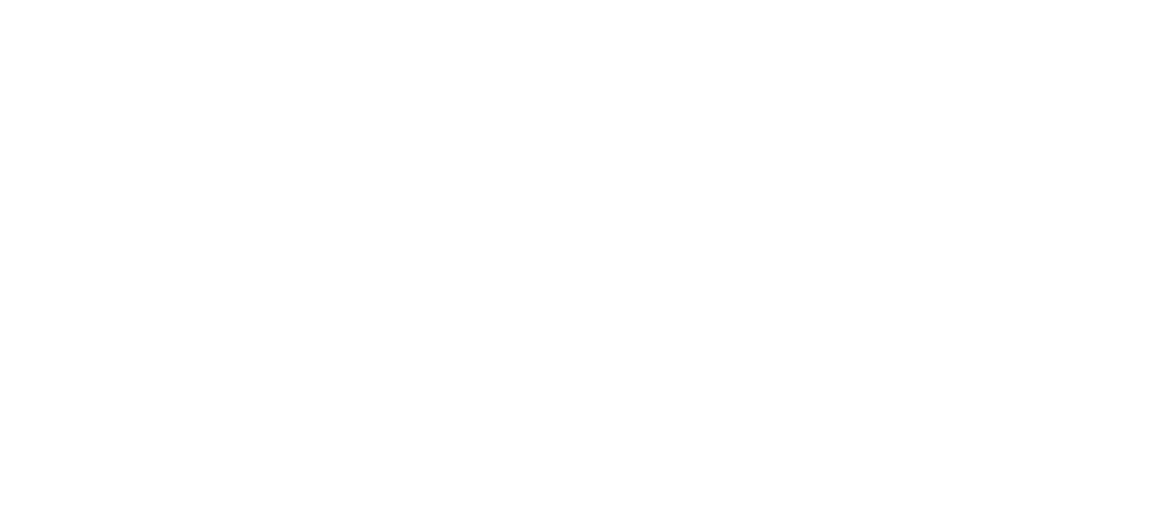

A Jupyter Widget

loss:1.8081, logdet:0.0094 pz:-1.8175 
loss:1.3124, logdet:0.1770 pz:-1.4894 
loss:0.8968, logdet:0.3424 pz:-1.2392 
loss:0.4742, logdet:0.4952 pz:-0.9693 
loss:0.2869, logdet:0.6674 pz:-0.9543 
loss:0.0063, logdet:0.7880 pz:-0.7943 
loss:-0.0136, logdet:0.9095 pz:-0.8959 
loss:-0.1160, logdet:0.8844 pz:-0.7684 
loss:-0.0154, logdet:0.8802 pz:-0.8648 
loss:-0.1110, logdet:0.7672 pz:-0.6562 
loss:-0.0312, logdet:0.8890 pz:-0.8577 
loss:-0.0312, logdet:0.8890 pz:-0.8577 latentstd:2.7862  recon_loss:0.0000
loss:-0.2242, logdet:0.8214 pz:-0.5971 
loss:-0.0930, logdet:0.9320 pz:-0.8390 
loss:-0.1783, logdet:0.9177 pz:-0.7393 
loss:-0.3110, logdet:0.9205 pz:-0.6095 
loss:0.0006, logdet:0.9669 pz:-0.9675 
loss:-0.2124, logdet:0.8516 pz:-0.6392 
loss:-0.2755, logdet:0.9659 pz:-0.6904 
loss:-0.3439, logdet:0.9713 pz:-0.6274 
loss:-0.2714, logdet:0.8844 pz:-0.6130 
loss:-0.4609, logdet:0.9639 pz:-0.5030 
loss:-0.4609, logdet:0.9639 pz:-0.5030 latentstd:2.8365  recon_loss:0.0000
loss:-0.2906, log

loss:-0.7965, logdet:0.7493 pz:0.0472 
loss:-0.8088, logdet:0.7174 pz:0.0914 
loss:-0.8851, logdet:0.8197 pz:0.0654 
loss:-0.8851, logdet:0.8197 pz:0.0654 latentstd:3.1294  recon_loss:0.0000
loss:-0.7449, logdet:0.7900 pz:-0.0452 
loss:-0.7814, logdet:0.7820 pz:-0.0006 
loss:-0.7029, logdet:0.7575 pz:-0.0546 
loss:-0.7775, logdet:0.6849 pz:0.0926 
loss:-0.7624, logdet:0.7177 pz:0.0447 
loss:-0.8404, logdet:0.7343 pz:0.1061 
loss:-0.7393, logdet:0.7564 pz:-0.0171 
loss:-0.7610, logdet:0.6881 pz:0.0728 
loss:-0.7369, logdet:0.7018 pz:0.0350 
loss:-0.8307, logdet:0.7353 pz:0.0955 
loss:-0.8307, logdet:0.7353 pz:0.0955 latentstd:3.1231  recon_loss:0.0000
loss:-0.7001, logdet:0.6961 pz:0.0040 
loss:-0.7043, logdet:0.6693 pz:0.0351 
loss:-0.7644, logdet:0.7055 pz:0.0589 
loss:-0.7858, logdet:0.7727 pz:0.0131 
loss:-0.7615, logdet:0.7353 pz:0.0262 
loss:-0.8055, logdet:0.7295 pz:0.0760 
loss:-0.7112, logdet:0.7164 pz:-0.0052 
loss:-0.7634, logdet:0.7291 pz:0.0344 
loss:-0.6378, logdet:0.6999 

loss:-0.8475, logdet:0.6938 pz:0.1537 
loss:-0.8399, logdet:0.7025 pz:0.1374 
loss:-0.7612, logdet:0.6913 pz:0.0700 
loss:-0.7612, logdet:0.6913 pz:0.0700 latentstd:3.1802  recon_loss:0.0000
loss:-0.7735, logdet:0.6915 pz:0.0820 
loss:-0.8289, logdet:0.7829 pz:0.0460 
loss:-0.8010, logdet:0.6597 pz:0.1413 
loss:-0.8068, logdet:0.6011 pz:0.2057 
loss:-0.8854, logdet:0.7678 pz:0.1176 
loss:-0.6885, logdet:0.7259 pz:-0.0374 
loss:-0.8590, logdet:0.7455 pz:0.1136 
loss:-0.7637, logdet:0.7354 pz:0.0283 
loss:-0.8147, logdet:0.6406 pz:0.1741 
loss:-0.8464, logdet:0.7420 pz:0.1045 
loss:-0.8464, logdet:0.7420 pz:0.1045 latentstd:3.0305  recon_loss:0.0000
loss:-0.8204, logdet:0.7456 pz:0.0748 
loss:-0.8272, logdet:0.7520 pz:0.0752 
loss:-0.7097, logdet:0.7145 pz:-0.0047 
loss:-0.8555, logdet:0.6721 pz:0.1833 
loss:-0.8073, logdet:0.6722 pz:0.1351 
loss:-0.7877, logdet:0.7308 pz:0.0570 
loss:-0.7756, logdet:0.7338 pz:0.0418 
loss:-0.8598, logdet:0.6942 pz:0.1656 
loss:-0.7859, logdet:0.7395 pz:

loss:-0.8217, logdet:0.7347 pz:0.0870 
loss:-0.7851, logdet:0.6425 pz:0.1426 
loss:-0.7625, logdet:0.6519 pz:0.1106 
loss:-0.7625, logdet:0.6519 pz:0.1106 latentstd:3.0545  recon_loss:0.0000
loss:-0.8404, logdet:0.7397 pz:0.1006 
loss:-0.7857, logdet:0.6814 pz:0.1043 
loss:-0.7773, logdet:0.6285 pz:0.1488 
loss:-0.7336, logdet:0.7032 pz:0.0304 
loss:-0.7915, logdet:0.6204 pz:0.1711 
loss:-0.8781, logdet:0.6769 pz:0.2012 
loss:-0.8512, logdet:0.7095 pz:0.1416 
loss:-0.8304, logdet:0.6832 pz:0.1472 
loss:-0.8607, logdet:0.7012 pz:0.1595 
loss:-0.9040, logdet:0.7451 pz:0.1589 
loss:-0.9040, logdet:0.7451 pz:0.1589 latentstd:2.9822  recon_loss:0.0000
loss:-0.8892, logdet:0.7861 pz:0.1031 
loss:-0.7473, logdet:0.6500 pz:0.0973 
loss:-0.8017, logdet:0.6672 pz:0.1345 
loss:-0.7562, logdet:0.7920 pz:-0.0358 
loss:-0.8187, logdet:0.6454 pz:0.1733 
loss:-0.8381, logdet:0.6722 pz:0.1658 
loss:-0.8131, logdet:0.7246 pz:0.0885 
loss:-0.8438, logdet:0.7785 pz:0.0652 
loss:-0.8458, logdet:0.7639 pz:0

loss:-0.8142, logdet:0.7286 pz:0.0856 
loss:-0.8971, logdet:0.7540 pz:0.1431 
loss:-0.8879, logdet:0.7694 pz:0.1185 
loss:-0.7666, logdet:0.6815 pz:0.0851 
loss:-0.8198, logdet:0.6947 pz:0.1251 
loss:-0.8780, logdet:0.7339 pz:0.1441 
loss:-0.8437, logdet:0.7275 pz:0.1162 
loss:-0.7941, logdet:0.6460 pz:0.1482 
loss:-0.8074, logdet:0.7140 pz:0.0934 
loss:-0.8927, logdet:0.7470 pz:0.1457 
loss:-0.7497, logdet:0.6992 pz:0.0506 
loss:-0.8972, logdet:0.7425 pz:0.1547 
loss:-0.9196, logdet:0.7379 pz:0.1817 
loss:-0.9196, logdet:0.7379 pz:0.1817 latentstd:3.1430  recon_loss:0.0000
loss:-0.6421, logdet:0.6612 pz:-0.0191 
loss:-0.8381, logdet:0.7077 pz:0.1305 
loss:-0.9146, logdet:0.7646 pz:0.1500 
loss:-0.8946, logdet:0.7861 pz:0.1086 
loss:-0.8411, logdet:0.7013 pz:0.1398 
loss:-0.8591, logdet:0.6994 pz:0.1596 
loss:-0.7357, logdet:0.6939 pz:0.0418 
loss:-0.9275, logdet:0.7317 pz:0.1957 
loss:-0.7968, logdet:0.7750 pz:0.0219 
loss:-0.8253, logdet:0.6852 pz:0.1401 
loss:-0.8253, logdet:0.6852 

<IPython.core.display.Javascript object>


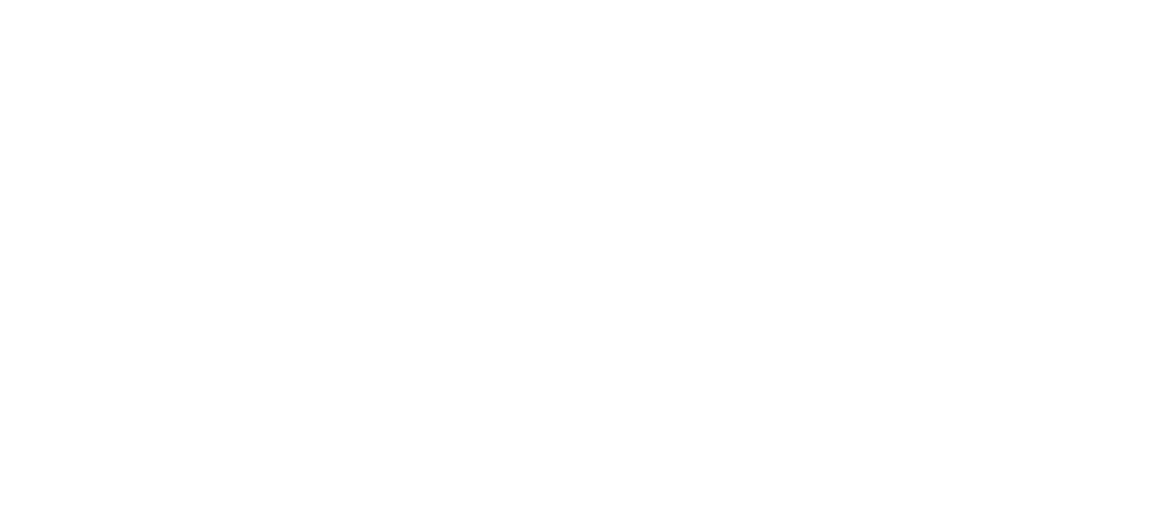

In [7]:
%matplotlib notebook
fig,(ax,ax2) = plt.subplots(1,2,figsize=(18,8))
axim = None
axscatter = None
fig.canvas.draw()

use_normal = True
pred_losses = []
pzes = []
logdets = []
losses = []
latent_numpys =[]

net = InvertibleResnetLinear(ndim,100,0.8, hidden_dim=64, reverse_iterations=40).cuda()
optim = Adam(net.parameters(), lr=0.0003, betas=(0.1,0.9))
for epoch in tqdm(range(0,10)):     
    for itercount in range(80):



        net.train()
        optim.zero_grad()
        latent, logdet = net(torch.randn((256,2)).cuda()  , return_logdet=True, num_logdet_iter=1) 
        logdet /= latent.shape[1]
        latentstd = torch.mean(latent.std(dim=0))

        pz = 0
        for d in dists:
            pz += torch.exp( -((latent - d) ** 2) / 2 )
        pz = torch.log(pz).sum(dim=1).mean()


        pz /= latent.shape[1]
        print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} '.format(
                -logdet.item()-pz.item(), logdet.item(),pz.item()))
        ( - logdet - pz).backward()

        pzes.append(pz.item())
        logdets.append(logdet.item())
        losses.append((-logdet-pz).item())
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()

        if itercount % 10 == 0:
            net.eval()
            latents = []
            for _itercount in range(10):
                train_batch = torch.randn((256,2)).cuda()
                latent = net(train_batch, return_logdet=False)
                latents.extend(latent.cpu().detach().numpy())

            with torch.no_grad():
                pred = net(latent[:1], reverse=True)
            latent_numpy = np.array(latents)


            recon_loss = F.mse_loss(train_batch[:1], pred)
            if itercount >0:
                print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} latentstd:{:.4f}  recon_loss:{:.4f}'.format(
                -logdet.item()-pz.item(), logdet.item(),pz.item(), latentstd.item(),  recon_loss.item()))



            pred_np = pred[0].cpu().detach().numpy().reshape((1,2))
            inp_np = train_batch[0].cpu().detach().numpy().reshape((1,2))
            disp = np.concatenate([pred_np, inp_np], axis=1)
            if axim:
                axim.set_data(disp)
            else:
                axim = ax.imshow(disp)


            ax2.clear()
            ax2.scatter(normal_np[:1000,0], normal_np[:1000,1], c='g')            
            ax2.scatter(latent_numpy[:1000,0], latent_numpy[:1000,1],  c='r')  
            fig.canvas.draw()
            latent_numpys.append(latent_numpy)
        del pz,  logdet, latent, latentstd
    #with torch.no_grad():
    #    for name, param in net.named_parameters():
    #        if '.weight' in name:
    #            param /= torch.sqrt((param ** 2).sum())

In [20]:
latent_numpys = np.array(latent_numpys)

In [21]:
latent_numpys.shape

(1, 80, 2560, 2)

In [22]:
latent_numpys = latent_numpys.reshape((-1,80,2560,2))

In [23]:
latent_numpy = latent_numpys[0,-1]

In [24]:
latent_numpy.shape

(2560, 2)

In [25]:
np.std(latent_numpy[np.logical_and(latent_numpy[:,0] > 0, latent_numpy[:,1] < 0)], axis=0)

array([1.0369779, 0.9552627], dtype=float32)

In [26]:
np.mean(latent_numpy[np.logical_and(latent_numpy[:,0] < 0, latent_numpy[:,1] < 0)], axis=0)

array([-3.0199525, -3.218392 ], dtype=float32)

<IPython.core.display.Javascript object>


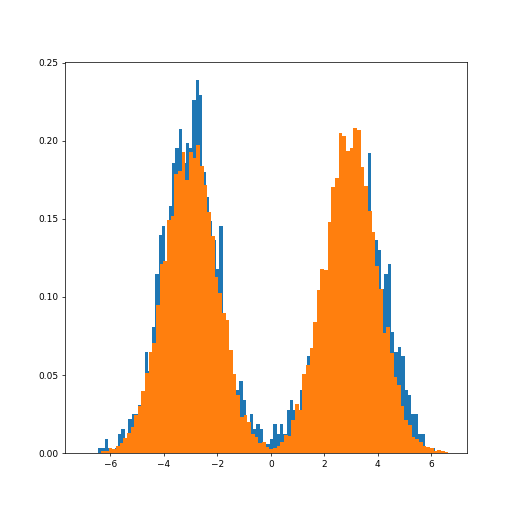

In [29]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0][i][-1]
        
        ax.clear()
        _ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
        _ = ax.hist(normal_np[:,1], bins=100, density=True)
        
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0][i][-1]
ax.clear()
_ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
_ = ax.hist(normal_np[:,1], bins=100, density=True)


fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)


<IPython.core.display.Javascript object>


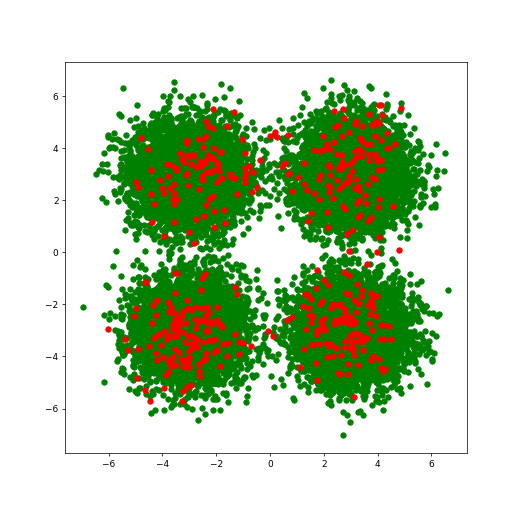

In [30]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0,i]
        
        ax.clear()
        ax.scatter(normal_np[:,0], normal_np[:,1], c='g') 
        ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0,i]
ax.clear()
ax.scatter(normal_np[:,0], normal_np[:,1], c='g')
ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)

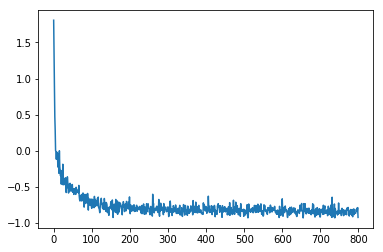

In [31]:
%matplotlib inline
plt.plot(range(len(losses[:])), losses[:])

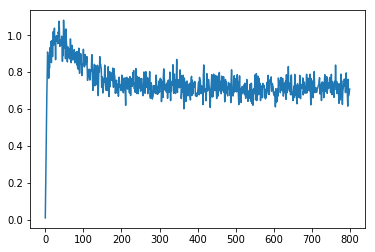

In [32]:
%matplotlib inline
plt.plot(range(len(logdets[:])), logdets[:])

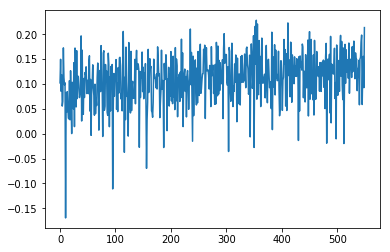

In [33]:
%matplotlib inline
plt.plot(range(len(pzes[250:])), pzes[250:])